<a href="https://colab.research.google.com/github/KatariinaIngerma/Text-classification/blob/main/kt_kodutoo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTAT.01.002 Keeletehnoloogia
#  Tekstide liigitamine

In [ ]:
# Colabi jaoks
!pip install estnltk==1.7.2

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.2/222.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00


In [ ]:
# Vajadusel kasutada üleslaetud failide lahtipakkimiseks
# Failide lahtipakkimine
#!unzip a_test.zip
#!unzip a_train.zip

In [ ]:
import random
import os
import pandas as pd
import re
import string
import nltk
from estnltk import Text
import estnltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import gensim
from gensim.models import Word2Vec
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
labels = ["www.advent.ee", "www.bioneer.ee", "www.lapsemure.ee", "www.naisteleht.ee", "arvamus.postimees.ee"]

# Korpuse sisselugemine (korpus asub programmifaili kausta alamkaustas)
def loaddata(corpus):
    columns = ['label', 'text']
    data = pd.DataFrame(columns = columns)
    for f in os.listdir(os.getcwd() + "/" + corpus):
        df = pd.read_csv(os.getcwd() + "/" + corpus + "/" + f, delimiter="\t", index_col=None, header=None, names=columns)
        data = pd.concat([data, df])
    data = data.reset_index(drop=True)
    return data

# Hindamine (testhulgal)
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja testkorpuses olev info DataFrame'ina
def evaluate(model, testset):
    correct = 0
    for i, row in testset.iterrows():
        rightAnswer = row['label']
        text = row['text']
        prediction = predict(model, text)
        #print(rightAnswer, prediction)
        if rightAnswer == prediction:
            correct += 1
    accuracy = correct/len(testset)
    print("Täpsus: {0:}%".format(100.0 * accuracy))
    return accuracy

# Treenimine
def train():
    # Treenime mudelit
    model = learn(trainset)
    return model

# Testimine
def test(model):
    # Hindame tulemusi testhulgal
    accuracy = evaluate(model, testset)
    return accuracy

In [ ]:

# Loeme sisse treeningandmed ja teisendame need DataFrame'i kujule
trainset = loaddata("a_train")
# Loeme sisse testandmed ja teisendame need DataFrame'i kujule
testset = loaddata("a_test")

## Mudel 1: Bag-of-words sõnade põhjal

In [ ]:
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
def learn(trainset):

    count_counts = count_vect.fit_transform(trainset['text'])

    count_tfidf = tfidf_transformer.fit_transform(count_counts)

    model = MultinomialNB().fit(count_tfidf, trainset["label"])

    return model
# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):

    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)


    predicted_label = model.predict(sample_tfidf)[0]

    return predicted_label

In [ ]:
model = train()

In [ ]:
test(model)

Täpsus: 60.333333333333336%


0.6033333333333334

## Mudel 2: Bag-of-words lemmade põhjal (stopp-sõnadega arvestamata)

In [ ]:
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
def learn(trainset):

    # Siia tuleb kirjutada kood, mis loob ja tagastab mudeli
    texts = trainset['text'].tolist()
    tekstidLemmalistidena = [Text(tekst).tag_layer().words.lemma for tekst in texts]
    lemmatiseeritud = [" ".join([lemma[0] for lemma in tekst]) for tekst in tekstidLemmalistidena]

    count_counts = count_vect.fit_transform(lemmatiseeritud)
    count_tfidf = tfidf_transformer.fit_transform(count_counts)

    model = MultinomialNB().fit(count_tfidf, trainset["label"])

    return model

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    cat = random.choice(labels)
    # Siia tuleb kirjutada kood, mis tagastab antud teksti liigi
    sample_lemmatized = " ".join([lemma[0] for lemma in Text(sample).tag_layer().words.lemma])

    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)


    predicted_label = model.predict(sample_tfidf)[0]

    return predicted_label

In [ ]:
def predict(model, sample):
    # Siia tuleb kirjutada kood, mis tagastab antud teksti liigi
    sample = " ".join([lemma[0] for lemma in Text(sample).tag_layer().words.lemma])

    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)


    predicted_label = model.predict(sample_tfidf)[0]

    return predicted_label

In [ ]:
model = train()

In [ ]:
test(model)

Täpsus: 59.333333333333336%


0.5933333333333334

## Mudel 3: Bag-of-words lemmade põhjal (stopp-sõnadega arvestades)

In [ ]:
stop_words = [
    "olema",
    "ja",
    "see",
    "tema",
    "mina",
    "ei",
    "et",
    "kui",
    "mis",
    "ka",
    "saama",
    "ning",
    "oma",
    "aga",
    "sina",
    "pidama",
    "siis",
    "või",
    "kes",
    "ju",
    "meie",
    "nii",
    "ise",
    "kuid",
    "kõik",
    "kas",
    "vaid",
    "mitte",
    "miski",
    "sest",
    "kus",
    "iga"
    ]


In [ ]:
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada
count_vect = CountVectorizer(stop_words=stop_words)
tfidf_transformer = TfidfTransformer()
def learn(trainset):
    texts = trainset['text'].tolist()
    tekstidLemmalistidena = [Text(tekst).tag_layer().words.lemma for tekst in texts]
    lemmatiseeritud = [" ".join([lemma[0] for lemma in tekst]) for tekst in tekstidLemmalistidena]

    count_counts = count_vect.fit_transform(lemmatiseeritud)
    count_tfidf = tfidf_transformer.fit_transform(count_counts)
    model = MultinomialNB().fit(count_tfidf, trainset["label"])
    return model

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    sample_lemmatized = " ".join([lemma[0] for lemma in Text(sample).tag_layer().words.lemma])

    # Transform the input text using CountVectorizer and TfidfTransformer
    sample_counts = count_vect.transform([sample_lemmatized])
    sample_tfidf = tfidf_transformer.transform(sample_counts)

    # Make predictions using the trained model
    predicted_label = model.predict(sample_tfidf)[0]

    return predicted_label

In [ ]:
model = train()

In [ ]:
test(model)

Täpsus: 67.66666666666666%


0.6766666666666666

## Mudel 4: Word2Veci abil

In [ ]:
import estnltk
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('lemmas.sg.s200.w2v.bin', binary=True)
def learn(trainset):
    # Siia tuleb kirjutada kood, mis loob ja tagastab mudeli
    X_train_word2vec = [text_vect(text) for text in trainset['text']]
    y_train = trainset['label']

    model = SVC(kernel='linear').fit(X_train_word2vec, y_train)
    return model

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    # Siia tuleb kirjutada kood, mis tagastab antud teksti liigi
    sample_vector = text_vect(sample)

    predicted_label = model.predict([sample_vector])[0]

    return predicted_label

# Sisend: tekst
# Väljund: vektor word2veci mudelist
def text_vect(text):
    words = text.split()
    vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    # Kui vektor on olemas
    if vectors:
        return sum(vectors) / len(vectors)
    else: # Kui vektorit pole siis 0 vektor samades dimesioonides
        return [0.0] * word2vec_model.vector_size

INFO:gensim.models.keyedvectors:loading projection weights from lemmas.sg.s200.w2v.bin


INFO:keyedvectors.py:2047: loading projection weights from lemmas.sg.s200.w2v.bin


INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (441391, 200) matrix of type float32 from lemmas.sg.s200.w2v.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-10-10T16:19:09.351272', 'gensim': '4.3.2', 'python': '3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]', 'platform': 'Linux-5.15.120+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


INFO:utils.py:448: KeyedVectors lifecycle event {'msg': 'loaded (441391, 200) matrix of type float32 from lemmas.sg.s200.w2v.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-10-10T16:19:09.351272', 'gensim': '4.3.2', 'python': '3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]', 'platform': 'Linux-5.15.120+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


In [ ]:
model = train()

In [ ]:
test(model)

Täpsus: 84.33333333333334%


0.8433333333333334

## Mudel 5: parima täpsusega mudel

In [ ]:
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('lemmas.sg.s200.w2v.bin', binary=True)
def learn(trainset):
    preprocessed_texts = [preprocess_text(text) for text in trainset['text']]

    X_train_word2vec = [text_vect(text) for text in preprocessed_texts]
    y_train = trainset['label']

    model = SVC(kernel='linear').fit(X_train_word2vec, y_train)
    return model

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    # Siia tuleb kirjutada kood, mis tagastab antud teksti liigi
    sample = preprocess_text(sample)
    words = sample.split()
    words = [word for word in words if word not in stop_words]
    sample = " ".join(words)
    sample_vector = text_vect(sample)

    predicted_label = model.predict([sample_vector])[0]

    return predicted_label

# Sisend: tekst
# Väljund: vektor word2veci mudelist
def text_vect(text):
    words = text.split()
    #Võtame stop-sõnad ära
    words = [word for word in words if word not in stop_words]
    vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    # Kui vektor on olemas
    if vectors:
        return sum(vectors) / len(vectors)
    else: # Kui vektorit pole siis 0 vektor samades dimesioonides
        return [0.0] * word2vec_model.vector_size

# Väike eeltöötlus
# Sisend: tekst
# Väljund: eeltöödeldud tekst, lowerc
def preprocess_text(text):
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))

  return text


INFO:gensim.models.keyedvectors:loading projection weights from lemmas.sg.s200.w2v.bin


INFO:keyedvectors.py:2047: loading projection weights from lemmas.sg.s200.w2v.bin


INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (441391, 200) matrix of type float32 from lemmas.sg.s200.w2v.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-10-10T16:19:32.048525', 'gensim': '4.3.2', 'python': '3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]', 'platform': 'Linux-5.15.120+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


INFO:utils.py:448: KeyedVectors lifecycle event {'msg': 'loaded (441391, 200) matrix of type float32 from lemmas.sg.s200.w2v.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-10-10T16:19:32.048525', 'gensim': '4.3.2', 'python': '3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]', 'platform': 'Linux-5.15.120+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


In [ ]:
model = train()

In [ ]:
test(model)

Täpsus: 88.33333333333333%


0.8833333333333333

## Analüüs ja diagramm


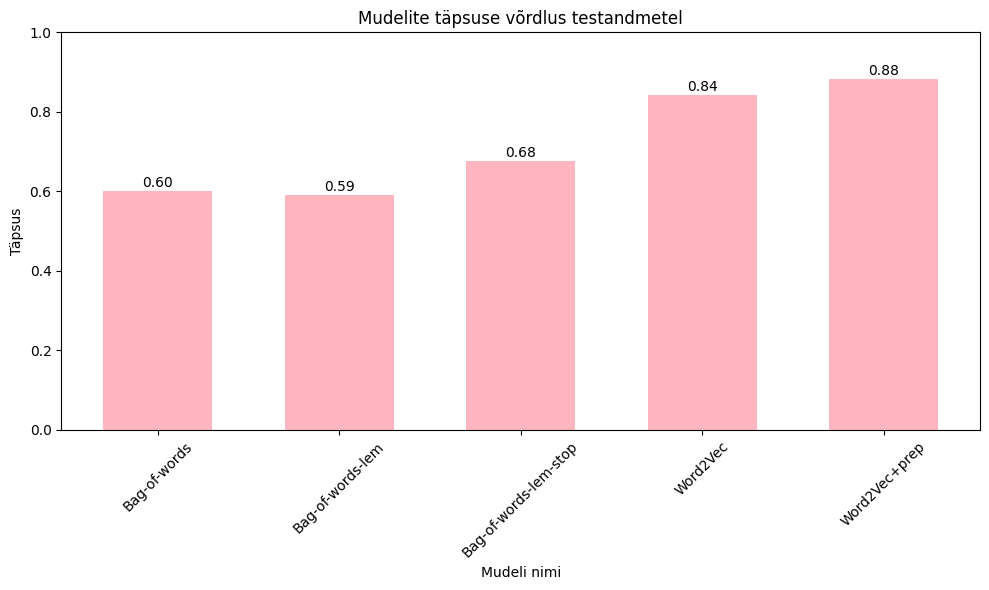

In [ ]:
import matplotlib.pyplot as plt

model_names = ["Bag-of-words", "Bag-of-words-lem", "Bag-of-words-lem-stop", "Word2Vec", "Word2Vec+prep"]
accuracies = [0.6, 0.59, 0.676, 0.843, 0.883]
bar_width = 0.6
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, width=bar_width, color='lightpink')
plt.xlabel("Mudeli nimi")
plt.ylabel("Täpsus")
plt.title("Mudelite täpsuse võrdlus testandmetel")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)

# täpsus
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center')

plt.tight_layout()
plt.show()

Esimene mudel andis tulemuse 0.6, mis on suheliselt kehva, teine mudel lemmatiseeritud andis sellest veel halvema tulemuse. Lemmatiseeritud ja ilma stop-sõnadeta oli tulemus parem -  0.67.
Word2vec andis hea tulemuse - 0.84.
Viimases mudelis kasutasin word2veci, sest see andis enne kõige täpsema tulemuse 0.84, tegin väikese eeltöötluse, et vaadata, kas saaks tulemust parandada. Sain lihtsa eeltöötlusega 0.883. Proovisin ka lemmatiseerida teksti, aga siis läks tulemus kehvemaks, võimalik et kadus mingi info konteksti kohta. Lisaks muutus lemmatiseerides tekst vähem mitmekesiseks.
Seega kõige paremaks mudeliks oli word2vec, millele tekstidele oli tehtud lihtne eeltöötlus (stop-sõnad, lowercase ja eemaldatud punktuatsioon). Võimalik, et ka teiste mudelite tulemused oleks eeltöötlusega paranenud, aga seda selles töös ei jõudnud katsetada. Stop-sõnade list oli ca 32 sõna, neid sõnu on kindlasti rohkem. Edaspidi võiks ka proovida teha täpsema listi ja vaadata, mis siis mudelite täpsused tulevad.  